# Import libraries

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import lightgbm
import catboost
import optuna
import tqdm as notebook_tqdm

# Load data

In [345]:
train_data = pd.read_csv('data/hackathon_income_train.csv', delimiter=';', decimal='.', parse_dates=['dt'], dayfirst=False)
train_data.head()

,id,dt,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,...,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
0,2,2024-04-30,"109324,47632478633","1465144,96",NaN,52800.0,"365346,244633755",23213.0,"97366,0",Женский,...,"1,0","0,0","57,0",0.0,"297,0","0,02702702702702703","9,0",NaN,"0,3012172807640372",NaN
1,4,2024-02-29,"25558,02866242038","303593,66",NaN,260200.0,NaN,10000.0,"32580,0",Женский,...,NaN,"0,0","707,0",67.0,"30245,0",NaN,"2,0",NaN,"0,6957996079578388",NaN
2,5,2024-02-29,"40666,753097982706","490754,01",NaN,2000000.0,NaN,90000.0,"96866,0",Женский,...,NaN,"422,0","0,0",0.0,"210322,0","0,0","20,0",NaN,"0,5159704060557002",NaN
3,6,2024-04-30,"43856,67205839414","219875,12",NaN,75000.0,NaN,75000.0,"43860,0",Мужской,...,NaN,"0,0","0,0",0.0,"7187,0","0,0","7,0",NaN,"0,4780029003784456",NaN
4,7,2024-04-30,"130420,85199232883","1750241,8449999997",NaN,1000000.0,NaN,240000.0,"83815,0",Женский,...,NaN,"0,0","84,0",0.0,"690038,0","0,0","9,0",NaN,"0,5523135540134384",NaN


In [346]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76786 entries, 0 to 76785
Columns: 224 entries, id to first_salary_income
dtypes: datetime64[ns](1), float64(34), int64(1), object(188)
memory usage: 131.2+ MB


In [347]:
test_data = pd.read_csv('data/hackathon_income_test.csv', delimiter=';', decimal='.', parse_dates=['dt'], dayfirst=False)
test_data.head()

,id,dt,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,avg_cur_cr_turn,...,total_sum,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,first_salary_income
0,0,2024-08-31,"805319,38",NaN,61137.47,NaN,60000.0,"159999,0",Женский,"69740,0",...,NaN,NaN,"0,0","0,0",NaN,"80228,0","0,0","1,0",NaN,NaN
1,1,2024-10-31,"306240,0",NaN,949500.00,NaN,230000.0,"108834,0",Мужской,"63513,0",...,"0,0",NaN,"0,0","0,0",0.0,"24888,0","0,0",NaN,NaN,NaN
2,3,2024-09-30,"164908,72999999998",NaN,178000.00,NaN,178000.0,"59203,0",Женский,"132,0",...,"38630,630000000005",NaN,"0,0","0,0",2363.9,"223,0",NaN,NaN,NaN,NaN
3,9,2024-10-31,"2374846,42",NaN,25500.00,"126247,44835851202",4999.0,"180906,0",Женский,"290339,0",...,NaN,"3,0","800,0","0,0",NaN,"25734,0","0,0","7,0","0,0",NaN
4,11,2024-11-30,"735902,71","47828,145620567375",60000.00,NaN,60000.0,"24922,0",Мужской,"76924,0",...,"0,0",NaN,"0,0","0,0",0.0,"1214,0","0,0","15,0",NaN,NaN


In [348]:
test_data.columns[65]

'dp_address_unique_regions'

In [349]:
train_data['dp_address_unique_regions'].dtype

dtype('O')

In [350]:
test_data.iloc[:,65].unique()

array([nan, '22', '25', '39', '61', '47', '77,50', '78', '74', '52', '71',
       '66', '59,66', '24', '16', '91,77,23', '23', '58', '67', '55',
       '35', '64', '77', '18', '50', '26', '50,12', '59', '86', '02',
       '30', '36', '38', '29', '72', '54', '73', '40', '61,23', '32',
       '42', '37', '50,25', '35,50', '77,21', '34', '05', '77,14', '76',
       '10,59', '66,72', '24,78', '40,77', '14', '11', '27', '33,52',
       '70', '46', '38,16,63', '21', '69', '74,55', '19', '63', '61,47',
       '75', '43,66', '89', '03', '62', '57,50', '12', '78,86', '56',
       '77,68', '47,78', '56,66', '68', '16,02', '47,72', '86,72', '51',
       '33', '23,66', '42,54', '10', '50,23', '60', '77,78', '02,16',
       '43,78', '50,77,16', '31', '43', '78,47', '45', '02,63', '50,77',
       '48', '16,12', '43,77', '94,61', '77,63', '57', '77,67', '22,42',
       '77,62', '86,77', '34,78', '13', '65', '71,54', '77,02,50',
       '26,42', '15,78', '21,77', '42,50', '50,32', '50,38', '23,31',
   

In [351]:
features = pd.read_csv('data/features_description.csv', delimiter=';', encoding='windows-1251')
features.head()

,признак,описание
0,dt,Дата актуальности признаков
1,target,таргет
2,turn_cur_cr_avg_act_v2,Средний текущий кредитовый оборот по текущим с...
3,salary_6to12m_avg,Усреднённая ЗП клиента за окно в минимум 6 мес...
4,hdb_bki_total_max_limit,БКИ: Максимальный кредитный лимит по любому пр...


In [352]:
features.shape

(224, 2)

# EDA

# Проверка уникальности клиентов/записей

In [353]:
set(train_data.id) & set(test_data.id)

set()

Пересекающихся клиентов нет

In [354]:
print(f'Всего записей: {train_data.shape[0]}\nКол-во уникальных id: {train_data.id.nunique()}')

Всего записей: 76786
Кол-во уникальных id: 76786


In [355]:
print(f'Всего {train_data.dtypes.nunique()} типов данных: {train_data.dtypes.unique()}')

Всего 4 типов данных: [dtype('int64') dtype('<M8[ns]') dtype('O') dtype('float64')]


In [356]:
train_data.select_dtypes(include='O').shape

(76786, 188)

In [357]:
def convert_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            # Replace comma with dot for decimal conversion
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            # Convert to numeric, coercing errors to NaN
            try:
                df[col] = df[col].astype(float)
            except Exception:
                continue
    return df

train_df = convert_numeric_columns(train_data)
test_df = convert_numeric_columns(test_data)


In [358]:
train_df.select_dtypes(include=['O']).columns

Index(['gender', 'adminarea', 'city_smart_name',
       'dp_ewb_last_employment_position', 'addrref',
       'dp_address_unique_regions', 'period_last_act_ad'],
      dtype='object')

In [359]:
for col in test_data.select_dtypes(include=['object']).columns:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

In [360]:
train_df.describe()

,id,dt,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,avg_cur_cr_turn,...,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
count,76786.000000,76786,7.678600e+04,5.907800e+04,1.487500e+04,6.741300e+04,1.650300e+04,6.304100e+04,63817.000000,6.021400e+04,...,16589.000000,55130.000000,55130.000000,5.573300e+04,7.316600e+04,34010.000000,34934.000000,1.113300e+04,76786.000000,8.668000e+03
mean,75070.250540,2024-04-28 15:29:52.170447616,9.264824e+04,1.170105e+06,1.174897e+05,1.353383e+06,2.162228e+05,2.504806e+05,81682.344469,1.866825e+05,...,1.454819,912.809305,275.162561,6.904705e+03,9.641689e+04,0.008593,12.909286,1.360850e+05,0.569014,2.052949e+05
min,2.000000,2024-01-31 00:00:00,2.000000e+04,1.000000e-02,2.000374e+04,0.000000e+00,2.648938e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,-2.000000e+00,0.000021,-7.982345e+04
25%,37519.250000,2024-03-31 00:00:00,3.970997e+04,2.039768e+05,4.872909e+04,1.908000e+05,9.280878e+04,7.140000e+04,46223.000000,1.580175e+04,...,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,5.000000,2.000000e+00,0.235950,1.264576e+05
50%,74975.500000,2024-04-30 00:00:00,6.275413e+04,5.940204e+05,7.309241e+04,5.772000e+05,1.497120e+05,1.550000e+05,67474.000000,7.436150e+04,...,1.000000,0.000000,0.000000,0.000000e+00,2.000000e+03,0.000000,10.000000,5.250000e+02,0.449424,1.769727e+05
75%,112835.500000,2024-05-31 00:00:00,1.002017e+05,1.268697e+06,1.222903e+05,1.693000e+06,2.422720e+05,3.000000e+05,101340.000000,1.754025e+05,...,2.000000,0.000000,0.000000,1.879960e+03,1.978700e+04,0.007463,18.000000,4.058000e+03,0.680337,2.378084e+05
max,149999.000000,2024-06-30 00:00:00,1.500000e+06,6.545863e+07,3.419392e+06,1.500000e+08,4.754632e+06,1.500000e+07,542084.000000,1.702021e+07,...,15.000000,287382.000000,310266.000000,1.519780e+06,4.263312e+07,0.428571,133.000000,2.374923e+08,2.570703,1.650302e+06
std,43362.283111,NaN,1.124090e+05,2.205263e+06,1.603782e+05,2.261767e+06,2.538178e+05,3.471460e+05,51306.983613,4.615432e+05,...,0.886676,6249.867314,2107.505699,3.522878e+04,5.695752e+05,0.022440,11.214355,2.517752e+06,0.551835,1.515545e+05


In [361]:
for i in range(features.shape[0]):
    print(features.iloc[i,0], '|', features.iloc[i,1]) 

dt | Дата актуальности признаков
target | таргет
turn_cur_cr_avg_act_v2 | Средний текущий кредитовый оборот по текущим счетам за 12 месяцев
salary_6to12m_avg | Усреднённая ЗП клиента за окно в минимум 6 месяцев и максимум 12 месяцев
hdb_bki_total_max_limit | БКИ: Максимальный кредитный лимит по любому продукту за все время
dp_ils_paymentssum_avg_12m | данные цифрового профиля
hdb_bki_total_cc_max_limit | БКИ: Максимальный лимит по кредитному продукту Кредитная карта за все время
incomeValue | Значение дохода абонента
gender | Пол клиента
avg_cur_cr_turn | Средний кредитовый оборот по текущим счетам за 3 месяца
adminarea | Регион клиента по geo cross model
turn_cur_cr_avg_v2 | Средний кредитовый оборот по текущим счетам за 12 месяцев
turn_cur_cr_max_v2 | Максимальный кредитовый оборот по текущим счетам за 12 месяцев
hdb_bki_total_pil_max_limit | БКИ: Максимальный лимит по кредитному продукту Кредит за все время
age | Возраст клиента
dp_ils_avg_salary_1y | данные цифрового профиля
turn_c

In [362]:
train_df['vert_has_app_ru_tinkoff_investing'].unique()

array([ 0., nan,  1.])

# Feature engineering

## Filling NA

In [363]:
print(train_df.isna().sum().sum())
cleaned_data = train_df.copy()

6938526


In [364]:
train_df['loan_cnt'].unique()

array([nan,  1.,  3.,  2.,  8.,  4.,  6.,  5., 10.,  7., 16.,  9., 20.,
       15., 12., 14., 11., 13., 19., 17.])

In [365]:
train_df['loan_cnt'].fillna(0, inplace=True)


/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_32527/3102414146.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['loan_cnt'].fillna(0, inplace=True)


In [ ]:
cols = test_df.columns

for col in cols:
    if (train_df[col].nunique() == 3 and None in train_df[col].unique() and train_df[col].dtype != 'object'):
        train_df[col].fillna(0, inplace=True)
    elif (train_df[col].dtype == 'float' and train_df[col].nunique() > 3):
        mean_col = np.mean(train_df[col])
        train_df[col].fillna(mean_col, inplace=True)

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_32527/2250698719.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mean_col, inplace=True)


In [ ]:
for col in cols:
    if (test_df[col].nunique() == 3 and None in test_df[col].unique() and test_df[col].dtype != 'object'):
        test_df[col].fillna(0, inplace=True)
    elif (test_df[col].dtype == 'float' and test_df[col].nunique() > 3):
        mean_col = np.mean(test_df[col])
        test_df[col].fillna(mean_col, inplace=True)

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_32527/1426539602.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[col].fillna(mean_col, inplace=True)


In [373]:
train_df.isna().sum().sum()

np.int64(200955)

In [368]:
imp = IterativeImputer(max_iter=250, random_state=23)

# Model train and test

In [374]:
# metric define
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return (weights * np.abs(y_true - y_pred)).mean()

In [375]:
X = train_df.drop(columns=['id', 'dt', 'target', 'w'])
object_col = X.select_dtypes(include=['object']).columns
X[object_col] = X[object_col].astype('category')
w = train_df['w']
y = train_df['target']

In [376]:
np.log2(X.shape[1])

np.float64(7.78135971352466)

## LightGBM

In [ ]:
def objective_lgbm(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 2000),
        'max_depth': trial.suggest_int("max_depth", 7, 9),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'n_jobs': -1,
        'random_state': 23
    }
    
    model = lightgbm.LGBMRegressor(**params, max_bin=1000)

    splitter = KFold(n_splits=5, shuffle=True, random_state=23)

    # y_log = np.log1p(y)

    wmean_mae = []

    for _, (train_index, valid_index) in enumerate(splitter.split(X, y)):

        X_train , y_train, w_train = X.iloc[train_index], y.iloc[train_index], w.iloc[train_index]
        X_valid, y_valid, w_valid = X.iloc[valid_index], y.iloc[valid_index], w.iloc[valid_index]

        model.fit(X_train, y_train, sample_weight=w_train,
                eval_metric='mae', eval_set=[(X_valid, y_valid)],
                    callbacks=[lightgbm.early_stopping(50), lightgbm.log_evaluation(period=0)])
        
        y_pred = model.predict(X_valid)
        wmean_mae.append(weighted_mean_absolute_error(y_valid, y_pred, w_valid)) #np.expm1(y_valid), np.expm1(y_pred)
    
    return np.mean(wmean_mae)

In [380]:
study = optuna.create_study(study_name="lgbm_opt", direction="minimize")
study.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

[I 2025-11-30 03:11:11,111] A new study created in memory with name: lgbm_opt


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162188
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from score 172097.969168
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's l1: 46777	valid_0's l2: 5.99486e+09
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162195
[LightGBM] [Info] Number of data points in the train set: 61429, number of used features: 220
[LightGBM] [Info] Start training from score 170310.118778
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[484]	valid_0's l1: 46607.2	valid_0's l2: 6.20727e+09
[L

In [381]:
print("Best value (WMAE):", study.best_value)
print("Best params:", study.best_trial.params)

Best value (WMAE): 37365.301494546184
Best params: {'n_estimators': 1988, 'max_depth': 8, 'num_leaves': 37, 'learning_rate': 0.03378713136330706, 'subsample': 0.7283598243184952, 'colsample_bytree': 0.6013615237860604, 'reg_alpha': 9.554286194490567, 'reg_lambda': 0.07727540944267751}


In [394]:
lgbm_reg = lightgbm.LGBMRegressor(**study.best_trial.params, max_bin=1000, random_state=23)

In [395]:
lgbm_reg.fit(X, y, sample_weight=train_df['w'], callbacks=[lightgbm.log_evaluation(period=0)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163315
[LightGBM] [Info] Number of data points in the train set: 76786, number of used features: 220
[LightGBM] [Info] Start training from score 170714.555839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,boosting_type,'gbdt'
,num_leaves,37
,max_depth,8
,learning_rate,0.03378713136330706
,n_estimators,1988
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


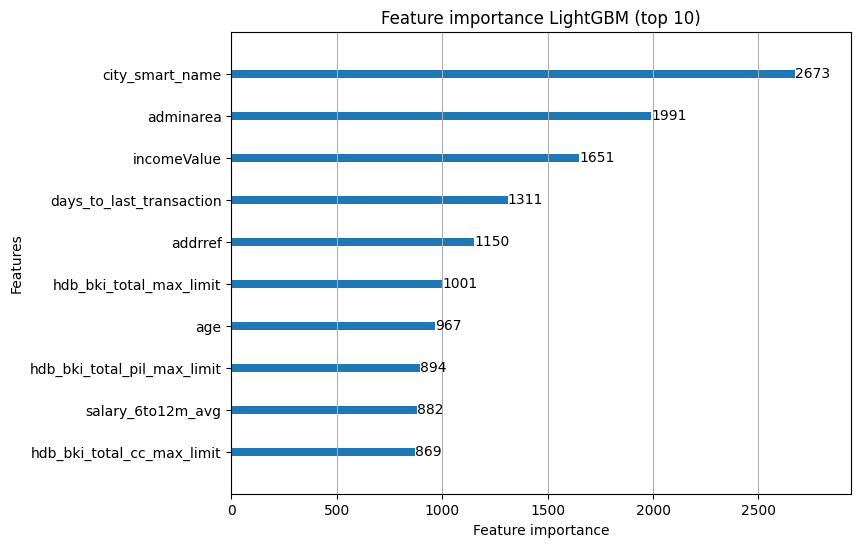

In [397]:
lightgbm.plot_importance(lgbm_reg, max_num_features=10, figsize=(8,6))
plt.title('Feature importance LightGBM (top 10)')
plt.grid(axis='y')

In [ ]:
# WMAE = weighted_mean_absolute_error(train_df['target'], train_df['predict'], train_df['w'])
# print(f"WMAE = {WMAE:.2f}")

# Save result

In [398]:
test_df[object_col] = test_df[object_col].astype('category')
preds = lgbm_reg.predict(test_df.drop(columns=['id', 'dt']))
result = pd.DataFrame(data={'ID':test_df['id'], 'target':preds})
result.to_csv("submission.csv", index=False, decimal='.', sep=',')